### Image Classification Models from Scratch

In [1]:
from fastai.vision.all import *

In [2]:
path = Path('C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/MNIST alphabet/')

In [3]:
items = get_image_files(path)

In [4]:
items[0]

Path('C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/MNIST alphabet/Train/#/__0_1004356.png')

<AxesSubplot:>

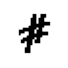

In [5]:
im = PILImageBW.create(items[0])
im.show()

In [6]:
splits = GrandparentSplitter(train_name='Train', valid_name='Validation')

In [7]:
items[:3]

(#3) [Path('C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/MNIST alphabet/Train/#/__0_1004356.png'),Path('C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/MNIST alphabet/Train/#/__0_1022082.png'),Path('C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/MNIST alphabet/Train/#/__0_1042459.png')]

In [8]:
splits = splits(items)

In [9]:
splits[0][:5], splits[1][:5]

([0, 1, 2, 3, 4], [834036, 834037, 834038, 834039, 834040])

In [10]:
dsrc = Datasets(items, tfms=[[PILImageBW.create], [parent_label, Categorize]],
                splits=splits)

<AxesSubplot:title={'center':'#'}>

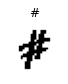

In [11]:
show_at(dsrc.train, 3)

In [12]:
tfms = [ToTensor(), CropPad(size=32, pad_mode=PadMode.Zeros), RandomCrop(size=32)]

In [13]:
gpu_tfms = [IntToFloatTensor(), Normalize()]

In [14]:
dls = dsrc.dataloaders(bs=4096, after_item=tfms, after_batch=gpu_tfms)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


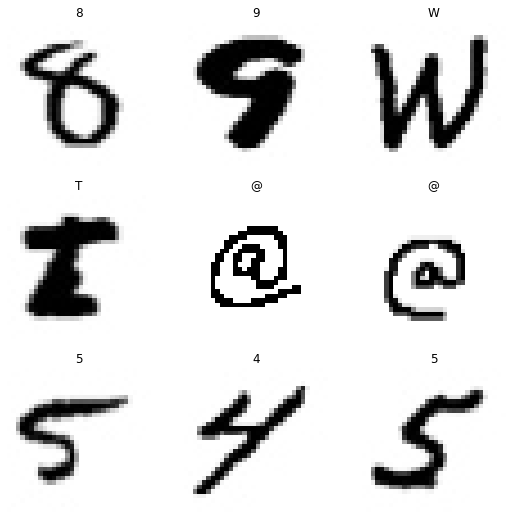

In [15]:
dls.show_batch()

In [16]:
xb, yb = dls.one_batch()

In [17]:
xb.shape, yb.shape

(torch.Size([4096, 1, 32, 32]), torch.Size([4096]))

In [18]:
dls.c

39

In [19]:
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=3, padding=1)

In [20]:
def bn(nf): return nn.BatchNorm2d(nf)

In [21]:
def ReLU(): return nn.ReLU(inplace=True)

In [22]:
model = nn.Sequential(
    conv(1,8),
    bn(8),
    ReLU(),
    conv(8,16),
    bn(16),
    ReLU(),
    conv(16,32),
    bn(32),
    ReLU(),
    conv(32,16),
    bn(16),
    ReLU(),
    conv(16,39),
    bn(39),
    Flatten()
)

In [23]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [24]:
learn.summary()

Sequential (Input shape: 4096)
Layer (type)         Output Shape         Param #    Trainable 
                     4096 x 8 x 11 x 11  
Conv2d                                    80         True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     4096 x 16 x 4 x 4   
Conv2d                                    1168       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     4096 x 32 x 2 x 2   
Conv2d                                    4640       True      
BatchNorm2d                               64         True      
ReLU                                                           
_________________________________________________

In [25]:
lr_valley = learn.lr_find(suggest_funcs=valley)

In [26]:
learn.fit_one_cycle(3, lr_max=lr_valley)

epoch,train_loss,valid_loss,accuracy,time
0,0.422696,0.537967,0.829116,18:10
1,0.286880,0.337371,0.892071,18:13
2,0.239640,0.272712,0.917510,17:45


In [27]:
def conv2(ni, nf): return ConvLayer(ni, nf, stride=2)

In [28]:
net = nn.Sequential(
    conv2(1,8),
    conv2(8,16),
    conv2(16,32),
    conv2(32,16),
    conv2(16,39),
    Flatten()
)

In [29]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [30]:
learn.fit_one_cycle(3, lr_max=lr_valley)

epoch,train_loss,valid_loss,accuracy,time
0,0.329175,0.434354,0.861037,16:56
1,0.214197,0.262444,0.909829,16:41
2,0.180717,0.204743,0.937311,16:15


In [31]:
class ResBlock(Module):
    def __init__(self, nf):
        self.conv1 = ConvLayer(nf, nf)
        self.conv2 = ConvLayer(nf, nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [32]:
net = nn.Sequential(
    conv2(1,8),
    ResBlock(8),
    conv2(8,16),
    ResBlock(16),
    conv2(16,32),
    ResBlock(32),
    conv2(32,16),
    ResBlock(16),
    conv2(16,39),
    Flatten()
)

In [33]:
net

Sequential(
  (0): ConvLayer(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (2): ConvLayer(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride

In [34]:
def conv_and_res(ni, nf): return nn.Sequential(conv2(ni, nf), ResBlock(nf))

In [35]:
net = nn.Sequential(
    conv_and_res(1,8),
    conv_and_res(8,16),
    conv_and_res(16,32),
    conv_and_res(32,16),
    conv(16,39),
    Flatten()
)

In [36]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [37]:
lr_valley = learn.lr_find(suggest_funcs=valley)

In [38]:
learn.fit_one_cycle(3, lr_max=lr_valley)

epoch,train_loss,valid_loss,accuracy,time
0,0.262061,0.271194,0.907432,17:25
1,0.175092,0.182813,0.944148,18:19
2,0.141536,0.157367,0.950897,18:45


### Stochastic Gradient Descent

In [2]:
from fastai.basics import *

In [23]:
import torch
from torch import nn

import numpy as np

import matplotlib.pyplot as plt

from fastai.torch_core import tensor

In [24]:
n = 100

In [25]:
x = torch.ones(n,2)

In [26]:
len(x), x[:5]

(100,
 tensor([[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]]))

In [27]:
x[:,0].uniform_(-1, 1)
x[:5], x.shape

(tensor([[-0.4084,  1.0000],
         [ 0.6955,  1.0000],
         [ 0.7466,  1.0000],
         [ 0.5244,  1.0000],
         [-0.0444,  1.0000]]),
 torch.Size([100, 2]))

In [28]:
m = tensor(3., 2); m, m.shape

(tensor([3., 2.]), torch.Size([2]))

In [29]:
b = torch.rand(n); b[:5], b.shape

(tensor([0.7386, 0.4398, 0.8626, 0.0843, 0.5174]), torch.Size([100]))

In [30]:
y = x@m + b

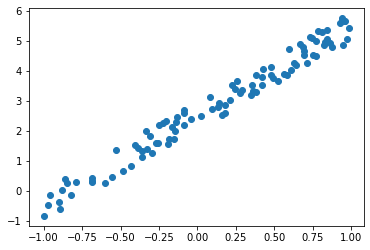

In [31]:
plt.scatter(x[:,0], y)

In [32]:
def mse(y_hat, y): return ((y_hat-y)**2).mean()

In [33]:
a = tensor(.5,.75)

In [34]:
y_pred = x@a

In [36]:
mse(y_pred, y)

tensor(6.5932)

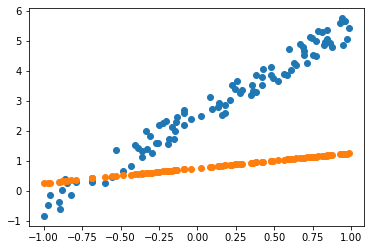

In [37]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],y_pred)

In [38]:
a = nn.Parameter(a); a

Parameter containing:
tensor([0.5000, 0.7500], requires_grad=True)

In [39]:
def update():
    y_hat = x@a
    loss = mse(y, y_hat)
    if i % 10 == 0: print(loss)
    loss.backward()
    with torch.no_grad():
        a.sub_(lr * a.grad)
        a.grad.zero_()

In [40]:
lr = 1e-1

In [41]:
for i in range(100): update()

tensor(6.5932, grad_fn=<MeanBackward0>)
tensor(0.5195, grad_fn=<MeanBackward0>)
tensor(0.1849, grad_fn=<MeanBackward0>)
tensor(0.1100, grad_fn=<MeanBackward0>)
tensor(0.0906, grad_fn=<MeanBackward0>)
tensor(0.0855, grad_fn=<MeanBackward0>)
tensor(0.0842, grad_fn=<MeanBackward0>)
tensor(0.0838, grad_fn=<MeanBackward0>)
tensor(0.0837, grad_fn=<MeanBackward0>)
tensor(0.0837, grad_fn=<MeanBackward0>)


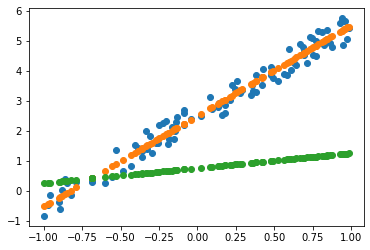

In [43]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0], (x@a).detach())
plt.scatter(x[:,0],y_pred)

In [44]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [45]:
a = nn.Parameter(tensor(0.5, 0.75)); a

Parameter containing:
tensor([0.5000, 0.7500], requires_grad=True)

In [46]:
def animate(i):
    update()
    line.set_ydata((x@a).detach())
    return line,

In [ ]:
fig = plt.figure()
plt.scatter(x[:,0], y, c='red')
line, = plt.plot(x[:,0])